In [3]:
%load_ext autoreload
%autoreload 2
import os
from utils.face_analyzer import FaceAnalyzer

face_analyzer = FaceAnalyzer()
participant_number = 5
frames = face_analyzer.get_video_frames_for_participant(participant_number,num_selected_frames= 20, is_consecutive_frames=True)

I0000 00:00:1741387317.415693 5252877 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741387317.437987 5254283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741387317.447321 5254283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Facial Landmarks

In [4]:
for frame in frames:
    detected_faces_landmarks = face_analyzer.process_image_results(frame.image)
    frame.facial_landmarks_obj= face_analyzer.get_largest_face_landmarks_obj(frame.image, detected_faces_landmarks)
    if frame.facial_landmarks_obj:
        frame.facial_landmarks = frame.facial_landmarks_obj.landmark

W0000 00:00:1741387318.114866 5254286 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


# Face

In [5]:

for frame in frames:
    if frame.facial_landmarks:
        frame.face = face_analyzer.get_face_coordinates(frame.facial_landmarks, frame.image)

# Smile

In [6]:
import numpy as np


SMOOTH_WINDOW = 5
happiness_buffer = []
def smooth_happiness(happiness_prob):
    if happiness_prob is None:
        return 0 # TODO: change?
    happiness_buffer.append(happiness_prob)
    if len(happiness_buffer) > SMOOTH_WINDOW:
        happiness_buffer.pop(0)
    return np.mean(happiness_buffer)


for i, frame in enumerate(frames):
    face_roi = face_analyzer.get_face_roi_image(frame.image, frame.face, expand_ratio=1.1)
    frame.smile = smooth_happiness(face_analyzer.get_smile_from_frame(face_roi))

# Selected Facial Features

In [7]:
for frame in frames:
    frame.selected_facial_landmarks = face_analyzer.get_selected_facial_landmarks(frame.facial_landmarks)

# Head Pose

In [8]:

texts = []
for frame in frames:
    result = face_analyzer.get_face_angles(frame.image, frame.facial_landmarks)
    frame.face_angles = result
    

# Prosodic Extraction

In [14]:
from models.prosodic_features import ProsodicFeatures
from utils.prosody_analyzer import ProsodyAnalyzer


prosody_analyzer = ProsodyAnalyzer(participant_number)
prosodic_features: ProsodicFeatures = prosody_analyzer.extract_all_features()

# Feature Storage

In [15]:
from utils.feature_storage import FeatureStorage

feature_storage = FeatureStorage()
feature_storage.save_to_csv(participant_number, prosodic_features)
print(prosodic_features)

ProsodicFeatures(f0_mean=143.17715191332044, f0_min=75.35218520766416, f0_max=599.3397908364293, f0_range=523.9876056287651, f0_sd=94.37915277916065, intensity_mean=-16.840087890625, intensity_min=-28.830551147460938, intensity_max=0.0, intensity_range=28.830551147460938, intensity_sd=5.876479625701904, f1_mean=712.8736104208981, f1_sd=352.11892436105046, f2_mean=1894.3971522929628, f2_sd=463.09513924595063, f3_mean=2929.48071136288, f3_sd=386.0899638604564, f2_f1_mean=3.088329877306074, f3_f1_mean=4.911027661150421, f2_f1_sd=1.2552739038244676, f3_f1_sd=1.9962691895494862, jitter=0.027095398025206375, shimmer=0.19659680893603956, percent_unvoiced=25.012495834721765, percent_breaks=3.6891442394918754, max_pause_duration=2.4899999999999984, avg_pause_duration=0.2953278688524591, duration=144.048)


# Display Frames

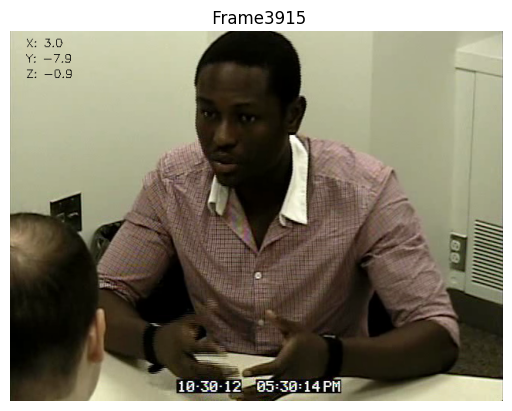

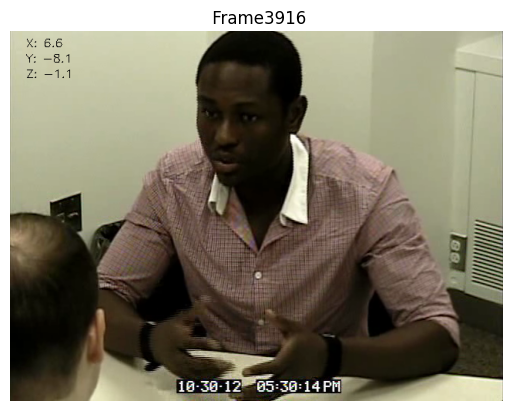

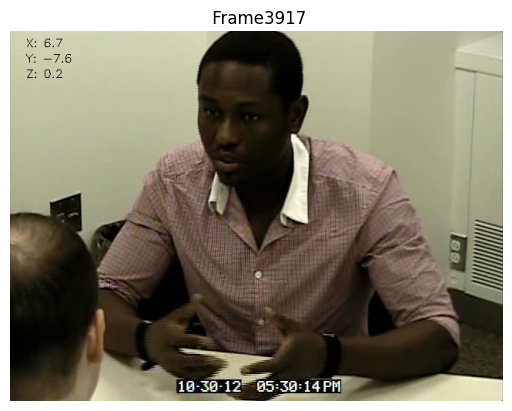

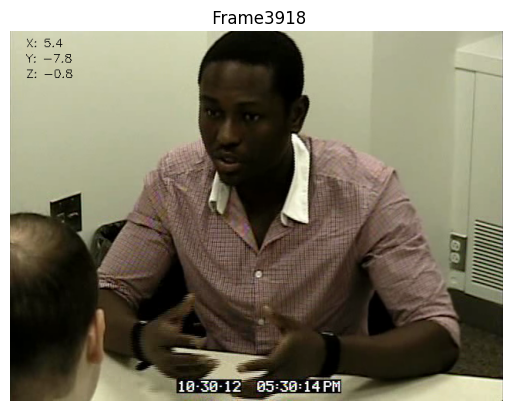

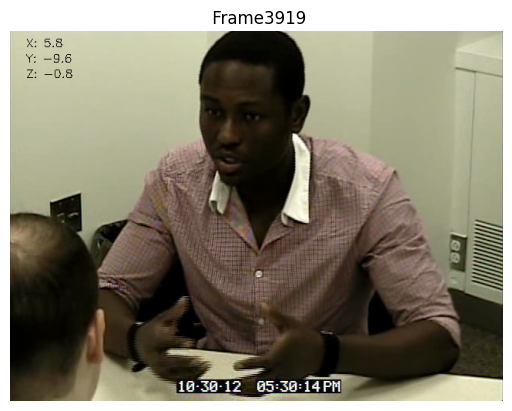

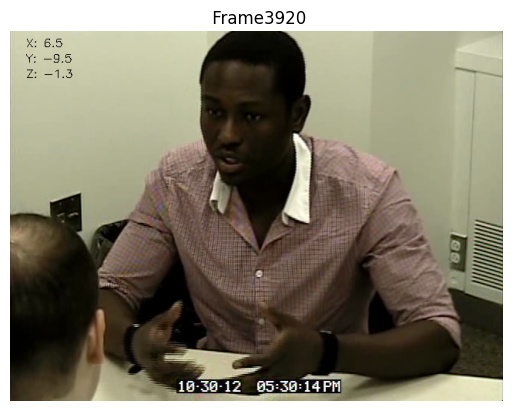

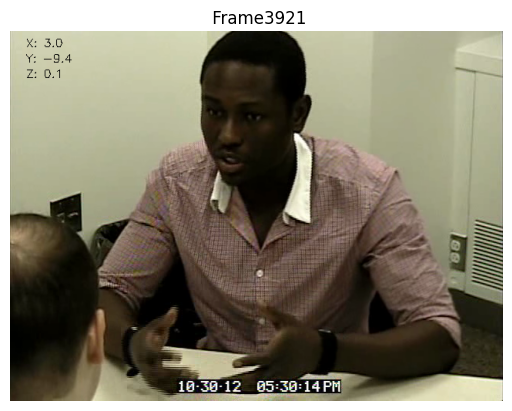

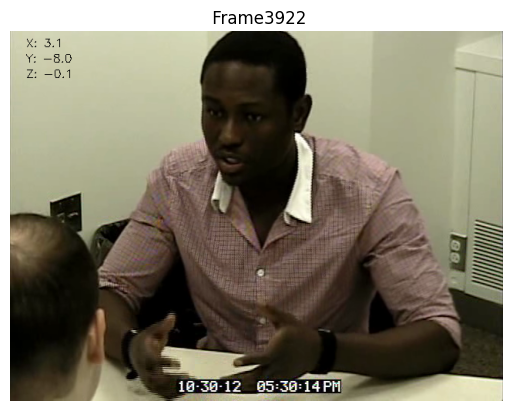

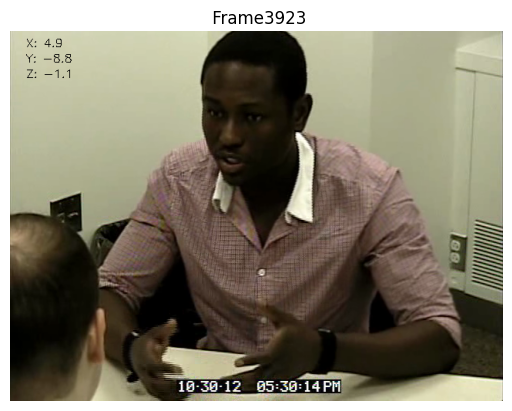

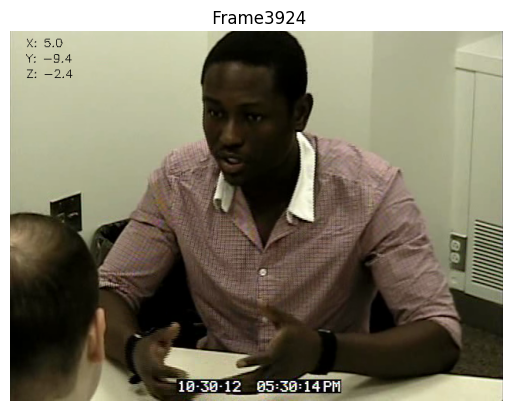

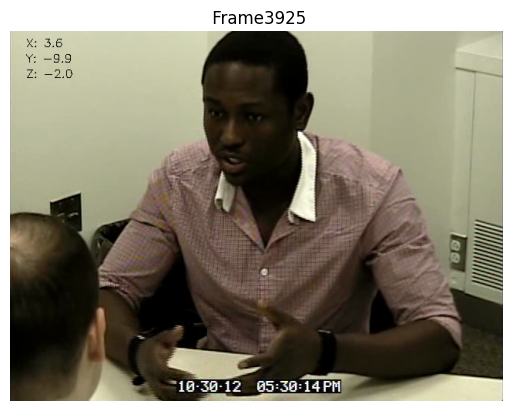

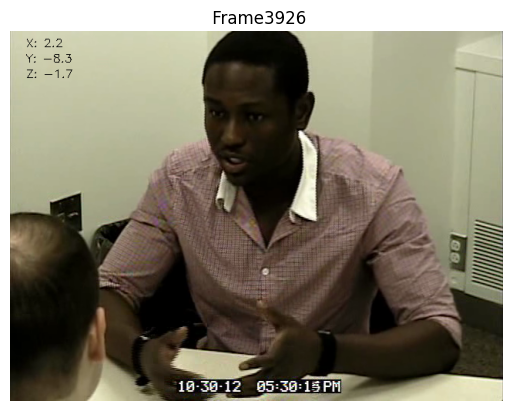

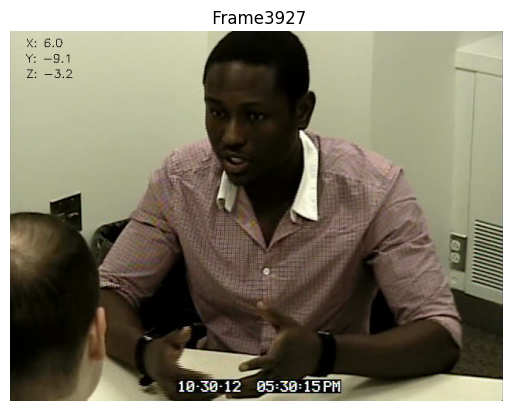

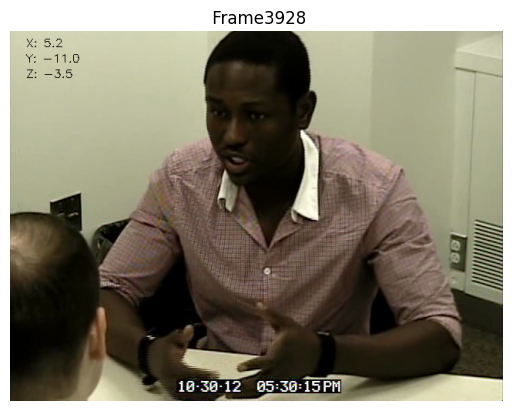

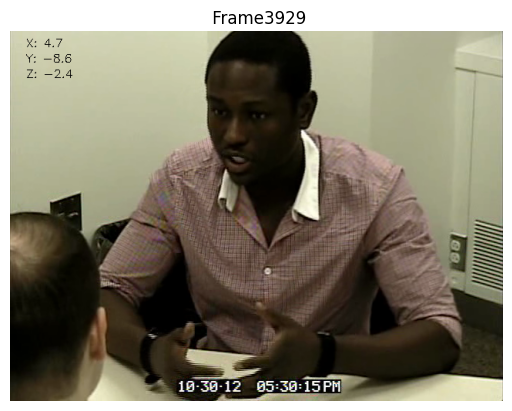

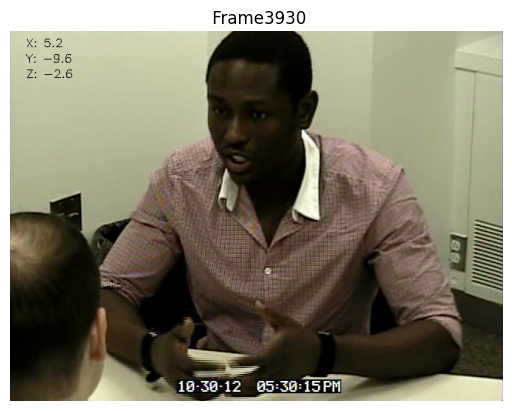

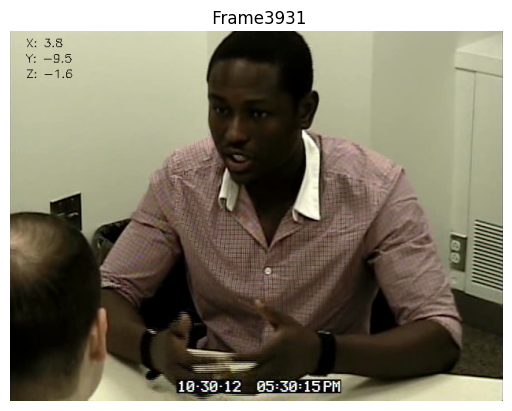

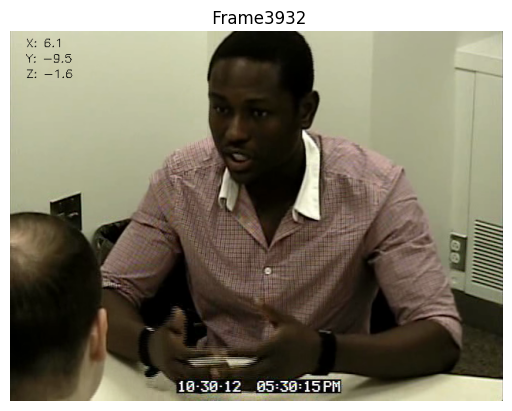

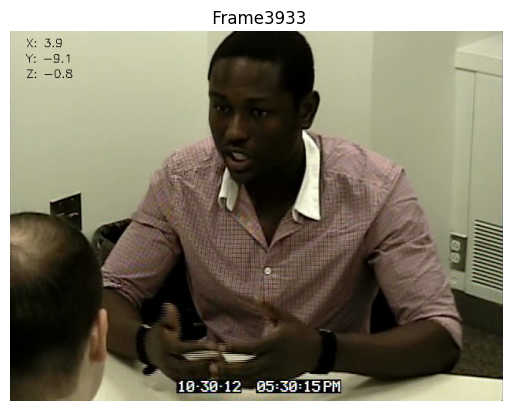

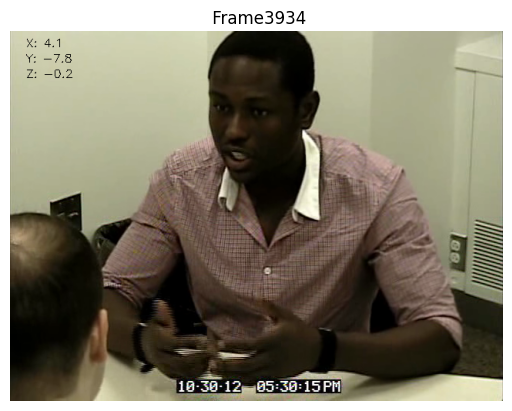

In [11]:
for frame in frames:
    frame.reset_drawable_image()
    # frame.draw_face()
    # frame.draw_smile()
    # frame.draw_selected_facial_landmarks(draw_lines=False)
    frame.put_face_angles()
    # frame.draw_facial_landmarks()
    frame.display()
